In [1]:
%matplotlib inline
import matplotlib.tri as tri
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import pandas as pd
import seaborn as sns

# Utility functions

In [2]:
# Embed Delta^2-Simplex points onto R^2
def get_simplexpoints(tripts):
    corners_tripts = np.zeros([tripts.shape[0], 2])
    corners_tripts[:, 0] = 0.5 * (2 * tripts[:, 1] + tripts[:, 2])
    corners_tripts[:, 1] = (np.sqrt(3) / 2) * (tripts[:, 2])
    return corners_tripts

# Get Delta^2-Simplex points from R^2 embedding
def get_triptspoints(simplex_points):
    corners_tripts = np.zeros([simplex_points.shape[0], 3])
    corners_tripts[:, 2] = 2 * simplex_points[:, 1] / np.sqrt(3)
    corners_tripts[:, 1] = (2 * simplex_points[:, 0] - corners_tripts[:, 2]) / 2
    corners_tripts[:, 0] = 1 - corners_tripts[:, 1] - corners_tripts[:, 2]
    return corners_tripts

# Recover boundaries from radius, angle pairs
def r_theta_to_xy(r, theta):
    base_simplex = get_simplexpoints(np.eye(3))
    ref_theta_0 = theta[:, 0]
    ref_theta_1 = theta[:, 1] + 2.0/3.0 * np.pi 
    ref_theta_2 = theta[:, 2] + 4.0/3.0 * np.pi

    dxy_0 = r[:, 0]*np.array([np.cos(ref_theta_0), np.sin(ref_theta_0)])
    dxy_1 = r[:, 1]*np.array([np.cos(ref_theta_1), np.sin(ref_theta_1)])
    dxy_2 = r[:, 2]*np.array([np.cos(ref_theta_2), np.sin(ref_theta_2)])

    # For "display" purposes, need to cap norm 1 to 1
    dxy_0 /= np.maximum(np.sum(np.abs(dxy_0), axis=0),1)[np.newaxis,:]
    dxy_1 /= np.maximum(np.sum(np.abs(dxy_1), axis=0),1)[np.newaxis,:]
    dxy_2 /= np.maximum(np.sum(np.abs(dxy_2), axis=0),1)[np.newaxis,:]

    xy_0 = base_simplex[0][:, np.newaxis] + dxy_0
    xy_1 = base_simplex[1][:, np.newaxis] + dxy_1
    xy_2 = base_simplex[2][:, np.newaxis] + dxy_2

    xy_0 = np.concatenate([base_simplex[0][:, np.newaxis], xy_0], axis=-1)
    xy_1 = np.concatenate([base_simplex[1][:, np.newaxis], xy_1], axis=-1)
    xy_2 = np.concatenate([base_simplex[2][:, np.newaxis], xy_2], axis=-1)

    return xy_0, xy_1, xy_2

# plot sets 
def shapely_plotter(N,color='red', alpha=0.5, ax = None):
    aux_list = np.array((N.exterior.coords))
    if ax is None:
        plt.plot(aux_list[:,0],aux_list[:,1],color=color)
        plt.fill(aux_list[:,0],aux_list[:,1],color=color, alpha=alpha)
    if ax is not None:
        ax.plot(aux_list[:,0],aux_list[:,1],color=color)
        ax.fill(aux_list[:,0],aux_list[:,1],color=color, alpha=alpha) 


#Samples star convex sets centered on simplex, returns radius and angles 
def sample_star_convex_candidate(N=8):
    theta= np.concatenate([np.random.uniform(0,1,[N-2,3]), np.zeros([1,3]), np.ones([1,3])])*np.pi*1.01/3
    theta = np.sort(theta, axis=0)

    midpoints= np.random.uniform(0.3,0.95,3)  

    r = np.random.uniform(0.05,1,[N,3])
    # check pairwise intersections
    r[0,0] = midpoints[0]
    r[-1,1]= 1-midpoints[0]+0.05
    r[0,1] = midpoints[1]
    r[-1,2]= 1-midpoints[1]+0.05
    r[0,2] = midpoints[2]
    r[-1,0]= 1-midpoints[2]+0.05
    return r, theta

#Samples Apstar-compliantstar convex sets
def sample_star_convex_apstar(N=8):
    #Samples Apstar-compliantstar convex sets
    # returns: r_star, theta_star: radius and angles of star convex sets wrt simplex corner
    #          lines: boundary list for all star convex sets
    #          Tri, N1, N2, N3, Nall, Nint : polygon objects for full simplex (Tri), N_i sets (N1-N3), and intersection and union of N_i (Nall Nint)
    base_simplex = get_simplexpoints(np.eye(3))
    while True:
        # Sample Star convex
        r_star, theta_star = sample_star_convex_candidate(N=N)
        lines = r_theta_to_xy(r_star, theta_star)
        Tri = Polygon(base_simplex)
        N1 = Polygon(np.concatenate([lines[0][0][:,np.newaxis],lines[0][1][:,np.newaxis]],axis=-1))
        N2 = Polygon(np.concatenate([lines[1][0][:,np.newaxis],lines[1][1][:,np.newaxis]],axis=-1))
        N3 = Polygon(np.concatenate([lines[2][0][:,np.newaxis],lines[2][1][:,np.newaxis]],axis=-1))
        Nall = N1.union(N2.union(N3))
        Nint = N1.intersection(N2.intersection(N3))
        if Nall.contains(Tri) and not Nint.is_empty:
            break
    return r_star, theta_star, lines, Tri, N1, N2, N3, Nall, Nint

# Check if simplex point belongs to N1, N2, and N3
def get_star_membership(simplex_point, N1,N2,N3):
    p = Point(simplex_point)
    return [p.distance(N1)<1e-4, p.distance(N2)<1e-4, p.distance(N3)<1e-4]

# Run apstar algorithm on sets
def apstar(mu,N1,N2,N3, max_it=500, K=1.0):
    mu_list=np.array(mu).reshape([1,-1])
    count=1
    membership = get_star_membership(get_simplexpoints(mu)[0],N1,N2,N3)
    membership = np.array(membership)
    while not membership.all() and count<= max_it:
        one_mu = (np.logical_not(membership)).astype('float32')
        one_mu /= one_mu.sum()
        mu = K/(K+1.0)* mu + 1/(K+1.0) *one_mu
        mu_list = np.concatenate([mu_list, mu.reshape([1,-1])])
        K+=1
        count+=1
        membership = get_star_membership(get_simplexpoints(mu)[0],N1,N2,N3)
        membership = np.array(membership)
    simplex_mu_list = get_simplexpoints(mu_list)
    success = membership.all()
    return mu_list, simplex_mu_list, membership.all()

# Show example trajectories and sets

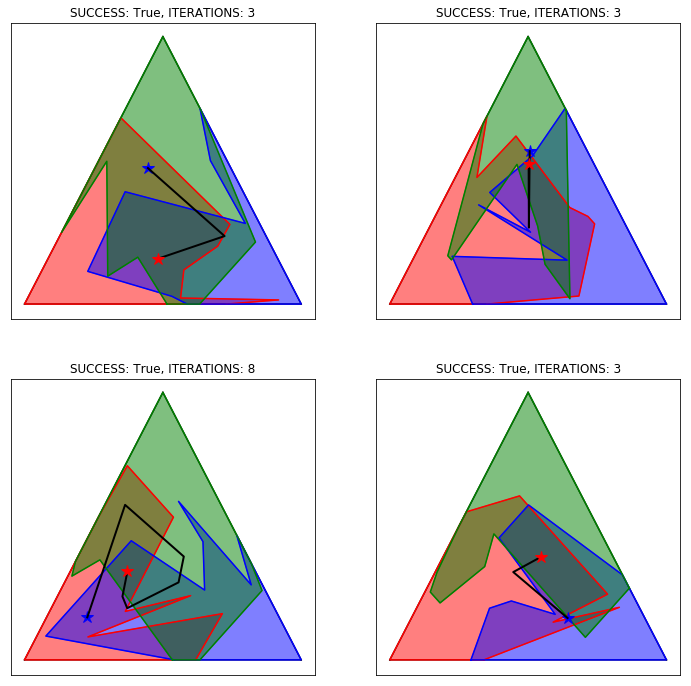

In [3]:
# np.random.seed(1)

plt.figure(figsize=(12, 12))
n_fig=2
success_list=[]
iter_list=[]
for it in range(n_fig**2):
    #Sample apstar-compliant star sets
    r_star, theta_star, lines, Tri, N1, N2, N3, Nall, Nint = sample_star_convex_apstar()
    
    # Sample intial conditions of apstar algorithm until a "bad" start is found (optional)
    # Then run APStar
    cnt=0
    while True:
        mu_ini =  np.random.dirichlet([1,1,1],size=1)
        mu_list, simplex_mu_list, success = apstar(mu_ini,N1,N2,N3)
        cnt+=1
        if len(mu_list)>1 or cnt>10:
            break
    
    #Store if run is successful and number of iterations
    success_list.append(success)
    iter_list.append(len(mu_list))
    
    
    #Display Star sets
    simplex_bound = get_simplexpoints(np.eye(3))
    triang_bound = tri.Triangulation(simplex_bound[:, 0], simplex_bound[:, 1])
    plt.subplot(n_fig,n_fig,it+1)
    plt.triplot(triang_bound, alpha=0.8, color='black')
    shapely_plotter(N1.intersection(Tri),color='red')
    shapely_plotter(N2.intersection(Tri),color='blue')
    shapely_plotter(N3.intersection(Tri),color='green')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 0.91])
    
    #Display Apstar trajectory
    plt.plot(simplex_mu_list[0,0],simplex_mu_list[0,1], '*', markersize=12, linewidth = 2, color='blue')
    plt.plot(simplex_mu_list[:,0],simplex_mu_list[:,1], '-', markersize=8, linewidth = 2, color='black')
    plt.plot(simplex_mu_list[-1,0],simplex_mu_list[-1,1], '*', markersize=12, linewidth = 2, color='red')

    plt.xticks([])
    plt.yticks([])
    plt.title('SUCCESS: ' + str(success) +', ITERATIONS: {:d}'.format(len(mu_list)))
plt.show()

# Run several simulations to recover empirical convergence times

In [ ]:
# Warning: Code to get APStar-compliant sets is slow
n_simulations=1000
success_list=[]
iter_list=[]
area_list=[]
poly_list=[]
mu_meta_list=[]
mu_meta_random_list=[]
for it in range(n_simulations):
    if it%50==0:
        print('Iteration:', it)
    #Sample apstar-compliant star sets
    r_star, theta_star, lines, Tri, N1, N2, N3, Nall, Nint = sample_star_convex_apstar()

    # Get Apstar trajectory from random start
    mu_ini =  np.random.dirichlet([1,1,1],size=1)
    mu_list, simplex_mu_list, success = apstar(mu_ini,N1,N2,N3)
    
    # Get Random sampler trajectory
    random_mu_list=[]
    while True:
        mu = np.random.dirichlet([1,1,1],size=1)
        random_mu_list.append(mu)
        if np.all(get_star_membership(get_simplexpoints(mu)[0],N1,N2,N3)):
            break
    
    poly_list.append([lines]) # save sets
    area_list.append(Nint.area/Tri.area) # relative area of triple intersection
    
    success_list.append(success) # save success of APStar
    iter_list.append(len(mu_list)) # number of APstar iterations
    mu_meta_list.append([mu_list]) # APStar trajectory
    mu_meta_random_list.append([random_mu_list]) # Random trajectory

Iteration: 0
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
Iteration: 300
Iteration: 350
Iteration: 400
Iteration: 450
Iteration: 500
Iteration: 550
Iteration: 600
Iteration: 650
Iteration: 700
Iteration: 750


# Make Boxplots of convergence times

In [ ]:
pct_list = np.percentile(area_list, [0,15,30,45,60,75,90,100])
pct_ticks = (pct_list[1:]+pct_list[:-1])/2.0
pandas_data=[]
np_iter_list=np.array(iter_list)
for idx in range(len(iter_list)):
    if len(np.where(area_list[idx]<pct_list)[0])<=0:
        continue
    pandas_data.append(
        [area_list[idx],iter_list[idx],np.min(np.where(area_list[idx]<pct_list)[0]),'APStar'])
    pandas_data.append(
        [area_list[idx],len(mu_meta_random_list[idx][0]),np.min(np.where(area_list[idx]<pct_list)[0]),'Random'])
dist_pandas_full = pd.DataFrame(data=pandas_data, columns=['area ratio','iterations','area bin', 'Method'])
dist_pandas= dist_pandas_full.loc[dist_pandas_full['Method']=='APStar']


import seaborn as sns
sns.set(style="ticks", palette="pastel", font_scale=3.5)

#reduced dataset for swarmplots
pct95_iter =np.percentile(dist_pandas['iterations'].values,[98])
dist_pandas_swarm = dist_pandas.copy()
dist_pandas_swarm =dist_pandas_swarm.loc[dist_pandas_swarm.iterations.values<=pct95_iter]

plt.figure(figsize=(12,8))
# ax = sns.swarmplot(x="area bin", y="iterations",data=dist_pandas_swarm,color=".25")
ax = sns.boxplot(x="area bin", y="iterations",
            data=dist_pandas, showfliers=False)

plt.xticks(np.arange(len(pct_ticks)),['{:.1f}%'.format(p*100.0) for p in pct_ticks])
plt.xlabel('area ratio')
sns.despine(offset=10, trim=True)
plt.show()


dist_pandas= dist_pandas_full.loc[dist_pandas_full['Method']=='Random']
#reduced dataset for swarmplots
pct95_iter =np.percentile(dist_pandas['iterations'].values,[98])
dist_pandas_swarm = dist_pandas.copy()
dist_pandas_swarm =dist_pandas_swarm.loc[dist_pandas_swarm.iterations.values<=pct95_iter]

plt.figure(figsize=(12,8))
# sns.swarmplot(x="area bin", y="iterations",data=dist_pandas_swarm,color=".25")
sns.boxplot(x="area bin", y="iterations",
            data=dist_pandas, showfliers=False)

plt.xticks(np.arange(len(pct_ticks)),['{:.1f}%'.format(p*100.0) for p in pct_ticks])
plt.xlabel('area ratio')
sns.despine(offset=10, trim=True)
plt.show()




plt.figure(figsize=(12,8))
# sns.swarmplot(x="area bin", y="iterations",data=dist_pandas_swarm,color=".25")
ax = sns.boxplot(x="area bin", y="iterations", hue='Method',
            data=dist_pandas_full, showfliers=False)
ax.set_yscale('log')

# plt.xticks(np.arange(len(pct_ticks)),np.round(100*pct_ticks,1))
plt.xticks(np.arange(len(pct_ticks)),['{:.0f}%'.format(p*100.0) for p in pct_ticks])
plt.xlabel('Area ratio')
sns.despine(offset=10, trim=True)
plt.show()